In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
from patsy import dmatrix

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import hddm

print(hddm.__version__)

0.9.8


In [125]:
%matplotlib inline

In [3]:
# function to generate rlddm-data that adds a neural regressor to decision threshold
def gen_rand_reg_rlddm_data(
    a,
    t,
    scaler,
    alpha,
    neural,
    size=1,
    p_upper=1,
    p_lower=0,
    z=0.5,
    q_init=0.5,
    split_by=0,
    subjs=1,
):
    all_data = []
    n = size
    # set sd for variables to generate subject-parameters from group distribution
    sd_t = 0.02
    sd_a = 0.1
    sd_alpha = 0.1
    sd_v = 0.25
    # save parameter values as group-values
    tg = t
    ag = a
    alphag = alpha
    scalerg = scaler
    for s in range(0, subjs):
        t = (
            np.maximum(0.05, np.random.normal(loc=tg, scale=sd_t, size=1))
            if subjs > 1
            else tg
        )
        a = (
            np.maximum(0.05, np.random.normal(loc=ag, scale=sd_a, size=1))
            if subjs > 1
            else ag
        )
        alpha = (
            np.minimum(
                np.minimum(
                    np.maximum(0.001, np.random.normal(loc=alphag, scale=sd_a, size=1)),
                    alphag + alphag,
                ),
                1,
            )
            if subjs > 1
            else alphag
        )
        scaler = (
            np.random.normal(loc=scalerg, scale=sd_v, size=1) if subjs > 1 else scalerg
        )
        # create a normalized regressor that is combined with the neural coefficient to create trial-by-trial values for decision threshold
        neural_reg = np.random.normal(0, 1, size=n)
        q_up = np.tile([q_init], n)
        q_low = np.tile([q_init], n)
        response = np.tile([0.5], n)
        feedback = np.tile([0.5], n)
        rt = np.tile([0], n)
        rew_up = np.random.binomial(1, p_upper, n).astype(float)
        rew_low = np.random.binomial(1, p_lower, n).astype(float)
        sim_drift = np.tile([0], n)
        subj_idx = np.tile([s], n)
        d = {
            "q_up": q_up,
            "q_low": q_low,
            "sim_drift": sim_drift,
            "rew_up": rew_up,
            "rew_low": rew_low,
            "response": response,
            "rt": rt,
            "feedback": feedback,
            "subj_idx": subj_idx,
            "split_by": split_by,
            "trial": 1,
            "neural_reg": neural_reg,
        }
        df = pd.DataFrame(data=d)
        df = df[
            [
                "q_up",
                "q_low",
                "sim_drift",
                "rew_up",
                "rew_low",
                "response",
                "rt",
                "feedback",
                "subj_idx",
                "split_by",
                "trial",
                "neural_reg",
            ]
        ]
        # generate data trial-by-trial using the Intercept (a), regressor (neural_reg) and coefficient (neural) for decision threshold.
        data, params = hddm.generate.gen_rand_data(
            {
                "a": a + neural * df.loc[0, "neural_reg"],
                "t": t,
                "v": df.loc[0, "sim_drift"],
                "z": z,
            },
            subjs=1,
            size=1,
        )
        df.loc[0, "response"] = data.response[0]
        df.loc[0, "rt"] = data.rt[0]
        if data.response[0] == 1.0:
            df.loc[0, "feedback"] = df.loc[0, "rew_up"]
        else:
            df.loc[0, "feedback"] = df.loc[0, "rew_low"]

        for i in range(1, n):
            df.loc[i, "trial"] = i + 1
            df.loc[i, "q_up"] = (
                df.loc[i - 1, "q_up"] * (1 - df.loc[i - 1, "response"])
            ) + (
                (df.loc[i - 1, "response"])
                * (
                    df.loc[i - 1, "q_up"]
                    + (alpha * (df.loc[i - 1, "rew_up"] - df.loc[i - 1, "q_up"]))
                )
            )
            df.loc[i, "q_low"] = (
                df.loc[i - 1, "q_low"] * (df.loc[i - 1, "response"])
            ) + (
                (1 - df.loc[i - 1, "response"])
                * (
                    df.loc[i - 1, "q_low"]
                    + (alpha * (df.loc[i - 1, "rew_low"] - df.loc[i - 1, "q_low"]))
                )
            )
            df.loc[i, "sim_drift"] = (df.loc[i, "q_up"] - df.loc[i, "q_low"]) * (scaler)
            data, params = hddm.generate.gen_rand_data(
                {
                    "a": a + neural * df.loc[i, "neural_reg"],
                    "t": t,
                    "v": df.loc[i, "sim_drift"],
                    "z": z,
                },
                subjs=1,
                size=1,
            )
            df.loc[i, "response"] = data.response[0]
            df.loc[i, "rt"] = data.rt[0]
            if data.response[0] == 1.0:
                df.loc[i, "feedback"] = df.loc[i, "rew_up"]
            else:
                df.loc[i, "feedback"] = df.loc[i, "rew_low"]
        all_data.append(df)
    all_data = pd.concat(all_data, axis=0)
    all_data = all_data[
        [
            "q_up",
            "q_low",
            "sim_drift",
            "response",
            "rt",
            "feedback",
            "subj_idx",
            "split_by",
            "trial",
            "neural_reg",
        ]
    ]

    return all_data

In [4]:
# Create data with function defined above.
# This will create trial-by-trial values for decision threshold (a) by adding the coefficient neural (here set to 0.2)
# multiplied by a normalized regressor (neural_reg) to the 'Intercept' value of a (here set to 1)
data_neural = gen_rand_reg_rlddm_data(
    a=1,
    t=0.3,
    scaler=2,
    alpha=0.2,
    neural=0.2,
    size=100,
    p_upper=0.7,
    p_lower=0.3,
    subjs=25,
)
data_neural["q_init"] = 0.5
data_neural.head(200)

,q_up,q_low,sim_drift,response,rt,feedback,subj_idx,split_by,trial,neural_reg,q_init
0,0.500000,0.500000,0.000000,1.0,0.679658,1.0,0,0,1,-0.192620,0.5
1,0.614283,0.500000,0.199774,1.0,0.843658,0.0,0,0,2,2.205121,0.5
2,0.473879,0.500000,-0.045661,0.0,0.549658,0.0,0,0,3,0.192803,0.5
3,0.473879,0.385717,0.154112,1.0,0.806658,1.0,0,0,4,0.828446,0.5
4,0.594132,0.385717,0.364322,1.0,0.464658,0.0,0,0,5,1.090848,0.5
...,...,...,...,...,...,...,...,...,...,...,...
95,0.795954,0.221637,1.139644,1.0,0.412635,1.0,1,0,96,-0.034621,0.5
96,0.827781,0.221637,1.202801,1.0,0.454635,1.0,1,0,97,-0.129284,0.5
97,0.854644,0.221637,1.256106,1.0,1.259635,1.0,1,0,98,-0.124575,0.5
98,0.877316,0.221637,1.301096,1.0,0.691635,0.0,1,0,99,1.517240,0.5


In [5]:
print(*data_neural["split_by"])

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [6]:
print(*data_neural["subj_idx"])

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 

In [7]:
print(*data_neural["trial"])

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 4

In [ ]:
m_reg = hddm.HDDMrlRegressor(data_neural, "alpha ~ neural_reg", include=["v", "a", "t", "alpha"])


In [14]:
m_reg.sample(300, burn=100)

 [-----------------81%-----------       ] 245 of 300 complete in 551.2 secHalting at iteration  244  of  300


In [ ]:
m_reg.print_stats()

In [9]:
m_rl = hddm.Hrl(
    data_neural
)

No model attribute --> setting up standard HDDM
Set model to ddm


/Users/corrado/mambaforge/envs/py37_env/lib/python3.7/site-packages/hddm/models/base.py:1310: UserWarning:  
 Your include statement misses either the v, a or t parameters. 
Parameters not explicitly included will be set to the defaults, 
which you can find in the model_config dictionary!
  + "which you can find in the model_config dictionary!"


In [10]:
m_rl.find_starting_values()


/Users/corrado/mambaforge/envs/py37_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [12]:
m_rl.sample(500, burn=100)

 [-----------------100%-----------------] 500 of 500 complete in 10.2 sec

## Marmotta

La domanda è se il principio decisionale dipenda dall'umore nel momento in cui viene fatta la valutazione. L'umore è stato giudicato dai soggetti su una scala da -50 a +50.

Considerata la distribuzione dei giudizi di umore, si è deciso di suddividere le osservazioni in tre gruppi: low, med, high, con un cut-off definito dai quantili di ordine 0.33 e 0.66.

Nella seguente analisi viene valutato l'effetto del livello d'umore (low, med, high) sul parametro drift rate.

In [128]:
df = hddm.load_csv("../../data/prep/groundhog_hddmrl_data.csv")
df.tail()

,subj_idx,user_id,epoch,days,control,fmood,mood_num,mood_pre,mood_post,rt,rt_inst,response,feedback,split_by,q_init,trial_in_block,trial
42025,243,905946028,2,7,1,high,3,27,11,0.884,0.598,1,0,1,0.5,26,206
42026,243,905946028,2,7,1,high,3,27,11,1.210,0.702,1,0,1,0.5,27,207
42027,243,905946028,2,7,1,high,3,27,11,1.182,1.345,1,0,1,0.5,28,208
42028,243,905946028,2,7,1,high,3,27,11,0.827,0.498,1,1,1,0.5,29,209
42029,243,905946028,2,7,1,high,3,27,11,1.634,0.639,1,0,1,0.5,30,210


In [129]:
m_rl = hddm.Hrl(
    df,
    depends_on={
        "alpha": ["mood_num", "days"],
        "v": ["mood_num", "days"]
    }
)

No model attribute --> setting up standard HDDM
Set model to ddm


/Users/corrado/mambaforge/envs/py37_env/lib/python3.7/site-packages/hddm/models/base.py:1310: UserWarning:  
 Your include statement misses either the v, a or t parameters. 
Parameters not explicitly included will be set to the defaults, 
which you can find in the model_config dictionary!
  + "which you can find in the model_config dictionary!"


In [130]:
m_rl.find_starting_values()

/Users/corrado/mambaforge/envs/py37_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [131]:
m_rl.sample(1500, burn=500)

 [                  0%                  ] 13 of 1500 complete in 25.4 sec

In [123]:
m_rl.print_stats()

                          mean       std      2.5q       25q       50q       75q     97.5q    mc err
v(1.1)                  1.6716  0.137904  1.387438  1.552583  1.726057  1.788422  1.816053  0.013774
v(1.2)                1.766895  0.121511  1.426632   1.76506  1.816401  1.832424  1.879068  0.012143
v(1.3)                1.740734   0.17007  1.323707  1.728284  1.804327  1.858969  1.914154  0.016998
v(2.1)                1.757424  0.212158  1.299714  1.605939  1.857198  1.912899  1.949224  0.021205
v(2.2)                1.719816  0.118321  1.479976  1.632156  1.780815  1.813729   1.83077  0.011824
v(2.3)                1.881524  0.123069  1.593278  1.848935  1.950314  1.964504  1.983755  0.012294
v(3.1)                1.810533  0.053005  1.727331  1.767657  1.792136  1.860447  1.917649  0.005257
v(3.2)                1.803417  0.094459  1.598769  1.773478  1.842165  1.875907  1.897823  0.009436
v(3.3)                 1.87167  0.056677  1.741518  1.859206  1.900866  1.908155  1.918914 

In [ ]:
m_rl.gen_stats()

In [122]:
v_low, v_med, v_high = m_rl.nodes_db.node[["v(1)", "v(2)", "v(3)"]]
hddm.analyze.plot_posterior_nodes([v_low, v_med, v_high])
plt.xlabel("Beta")
plt.ylabel("Posterior probability")
plt.title("Posterior of beta group means")

KeyError: "None of [Index(['v(1)', 'v(2)', 'v(3)'], dtype='object')] are in the [index]"

Text(0.5, 1.0, 'Posterior of alpha group means')

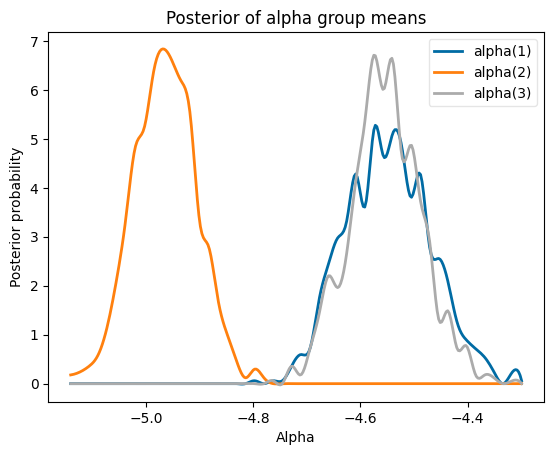

In [105]:
alpha_low, alpha_med, alpha_high = m_rl.nodes_db.node[["alpha(1)", "alpha(2)", "alpha(3)"]]
hddm.analyze.plot_posterior_nodes([alpha_low, alpha_med, alpha_high])
plt.xlabel("Alpha")
plt.ylabel("Posterior probability")
plt.title("Posterior of alpha group means")

# NN

In [62]:
hddm.model_config.model_config.keys()


dict_keys(['ddm_hddm_base', 'full_ddm_hddm_base', 'ddm', 'angle', 'weibull', 'levy', 'full_ddm', 'ornstein', 'ddm_sdv', 'gamma_drift', 'gamma_drift_angle', 'ds_conflict_drift', 'ds_conflict_drift_angle', 'ddm_par2', 'ddm_par2_no_bias', 'ddm_par2_angle_no_bias', 'ddm_par2_weibull_no_bias', 'ddm_seq2', 'ddm_seq2_no_bias', 'ddm_seq2_angle_no_bias', 'ddm_seq2_weibull_no_bias', 'ddm_mic2_adj', 'ddm_mic2_adj_no_bias', 'ddm_mic2_adj_angle_no_bias', 'ddm_mic2_adj_weibull_no_bias', 'tradeoff_no_bias', 'tradeoff_angle_no_bias', 'tradeoff_weibull_no_bias', 'tradeoff_conflict_gamma_no_bias', 'race_no_bias_3', 'race_no_bias_angle_3', 'race_no_bias_4', 'race_no_bias_angle_4', 'lca_no_bias_3', 'lca_no_bias_angle_3', 'lca_no_bias_4', 'lca_no_bias_angle_4', 'full_ddm2'])

In [49]:
# Metadata
nmcmc = 500
burn = 200
model = 'angle'

In [50]:
hddmnn_model_cav = hddm.HDDMnn(
    df,
    model=model,
    informative=False,
    include=hddm.simulators.model_config[model]["hddm_include"],
    p_outlier=0.05,
    is_group_model=True,
    depends_on={"v": "fmood"},
)

Supplied model_config specifies params_std_upper for  z as  None.
Changed to 10


In [ ]:
# Looking at the doc string before using the model
hddmnn_model_cav.sample(nmcmc, burn = burn)

## HDDM

In [ ]:
m_stim = hddm.HDDM(
    df, 
    depends_on={
        "v": "mood_num",
        "a": "mood_num", 
        "t": "mood_num"
    }
)

In [ ]:
m_stim.find_starting_values()

In [ ]:
m_stim.sample(500, burn=100)

Text(0.5, 1.0, 'Posterior of drift-rate group means')

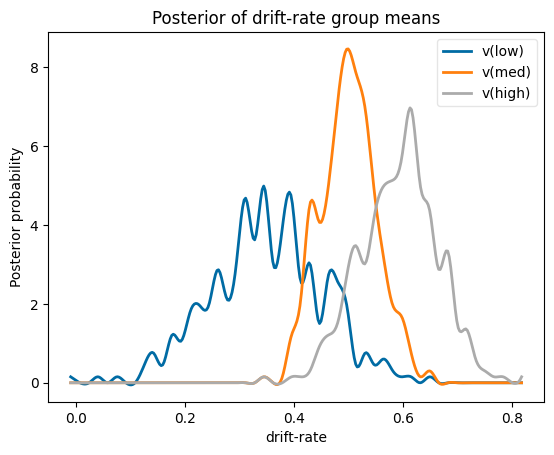

In [140]:
v_low, v_med, v_high = m_stim.nodes_db.node[["v(low)", "v(med)", "v(high)"]]
hddm.analyze.plot_posterior_nodes([v_low, v_med, v_high])
plt.xlabel("drift-rate")
plt.ylabel("Posterior probability")
plt.title("Posterior of drift-rate group means")


In [141]:
m_within_subj = hddm.HDDMRegressor(df, "v ~ C(fmood, Treatment('low'))")

No model attribute --> setting up standard HDDM
Set model to ddm


In [142]:
m_within_subj.sample(500, burn=200)

 [-----------------100%-----------------] 501 of 500 complete in 2265.6 sec

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

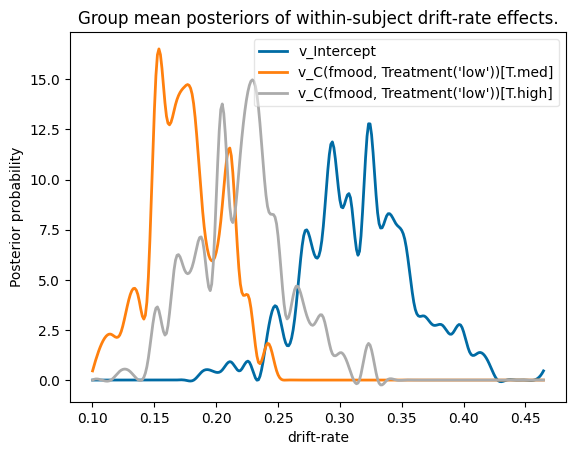

In [143]:
v_low, v_med, v_high = m_within_subj.nodes_db.loc[
    [
        "v_Intercept",
        "v_C(fmood, Treatment('low'))[T.med]",
        "v_C(fmood, Treatment('low'))[T.high]",
    ],
    "node",
]
hddm.analyze.plot_posterior_nodes([v_low, v_med, v_high])
plt.xlabel("drift-rate")
plt.ylabel("Posterior probability")
plt.title("Group mean posteriors of within-subject drift-rate effects.")


In [144]:
m_within_subj.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.380277,0.042815,2.297868,2.349576,2.383621,2.410745,2.463639,0.002863
a_std,0.611281,0.034962,0.547588,0.585808,0.614157,0.636593,0.682021,0.002546
a_subj.1,1.577501,0.168845,1.265415,1.444624,1.574831,1.695891,1.930448,0.012478
a_subj.2,3.035625,0.225647,2.599164,2.870318,3.024713,3.184486,3.483094,0.016055
a_subj.3,2.10331,0.12712,1.855641,2.019021,2.10235,2.179515,2.378797,0.009772
...,...,...,...,...,...,...,...,...
v_Intercept_subj.237,-0.0923,0.096264,-0.288332,-0.157045,-0.090289,-0.023781,0.081907,0.005421
v_Intercept_subj.238,1.378621,0.188442,1.040568,1.251163,1.373067,1.490563,1.76945,0.015274
v_Intercept_subj.239,0.475156,0.111392,0.270422,0.397291,0.472355,0.543767,0.721031,0.006037
"v_C(fmood, Treatment('low'))[T.high]",0.221618,0.036034,0.154154,0.199104,0.222903,0.242462,0.297967,0.003245


Faccio ora dipendere tutti i 3 parametri del DDM dal livello di umore.

In [ ]:
m2_stim = hddm.HDDM(
    df, 
    depends_on={
        "v": "fmood",
        "a": "fmood",
        "t": "fmood"
        }
)
m2_stim.find_starting_values()
m2_stim.sample(500, burn=100)

Text(0.5, 1.0, 'Posterior of drift-rate group means')

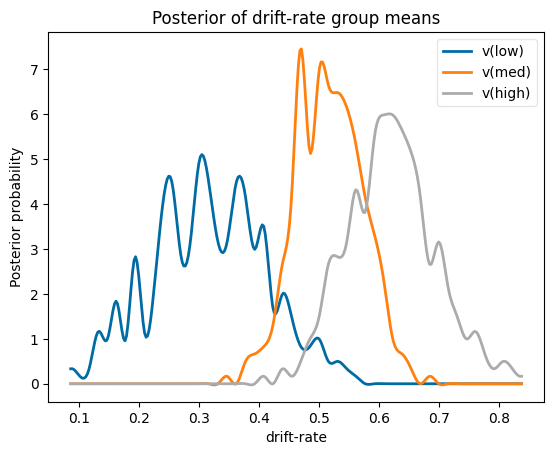

In [146]:
v_low, v_med, v_high = m2_stim.nodes_db.node[["v(low)", "v(med)", "v(high)"]]
hddm.analyze.plot_posterior_nodes([v_low, v_med, v_high])
plt.xlabel("drift-rate")
plt.ylabel("Posterior probability")
plt.title("Posterior of drift-rate group means")

Text(0.5, 1.0, 'Posterior of a group means')

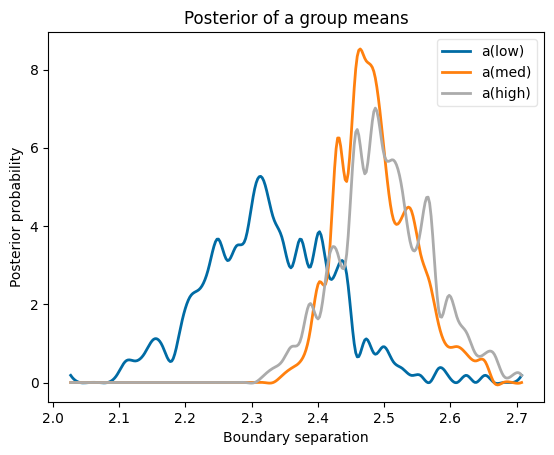

In [151]:
a_low, a_med, a_high = m2_stim.nodes_db.node[["a(low)", "a(med)", "a(high)"]]
hddm.analyze.plot_posterior_nodes([a_low, a_med, a_high])
plt.xlabel("Boundary separation")
plt.ylabel("Posterior probability")
plt.title("Posterior of a group means")

Text(0.5, 1.0, 'Posterior of t group means')

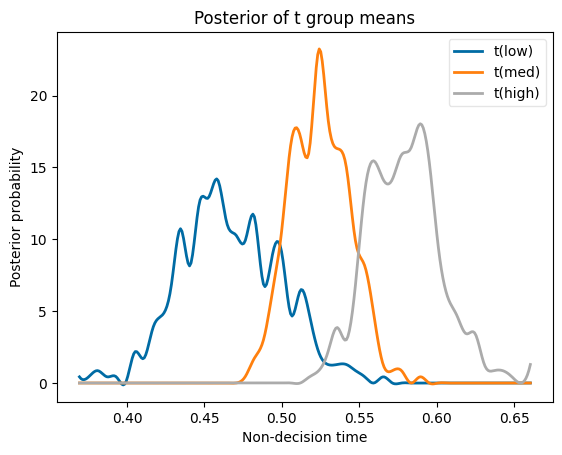

In [150]:
t_low, t_med, t_high = m2_stim.nodes_db.node[["t(low)", "t(med)", "t(high)"]]
hddm.analyze.plot_posterior_nodes([t_low, t_med, t_high])
plt.xlabel("Non-decision time")
plt.ylabel("Posterior probability")
plt.title("Posterior of t group means")

## HDDMRL

In [107]:
m3_stim = hddm.HDDMrl(
    df, 
    depends_on={
        "alpha": "mood_num",
        "v": "mood_num",
        "a": "mood_num",
        "t": "mood_num"
        },
    dual=True,
    p_outlier=0.05
)

No model attribute --> setting up standard HDDM
Set model to ddm


In [108]:
m3_stim.find_starting_values()

In [109]:
m3_stim.sample(500, burn=100)

 [-----------------100%-----------------] 501 of 500 complete in 1301.7 sec

In [ ]:
v_low, v_med, v_high = m3_stim.nodes_db.node[["v(1)", "v(2)", "v(3)"]]
hddm.analyze.plot_posterior_nodes([v_low, v_med, v_high])
plt.xlabel("drift-rate")
plt.ylabel("Posterior probability")
plt.title("Posterior of drift-rate group means")

Text(0.5, 1.0, 'Posterior of alpha-rate group means')

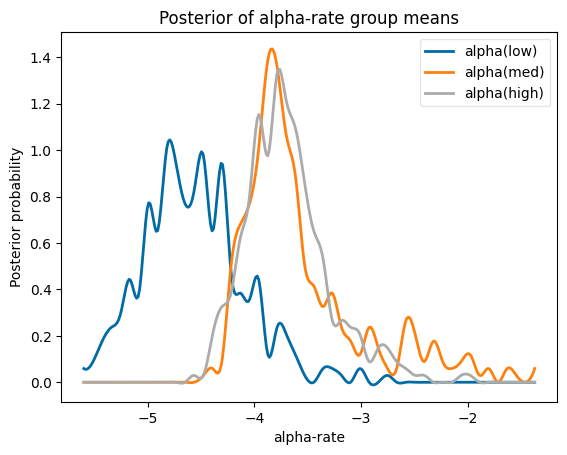

In [156]:
alpha_low, alpha_med, alpha_high = m3_stim.nodes_db.node[["alpha(1)", "alpha(2)", "alpha(3)"]]
hddm.analyze.plot_posterior_nodes([alpha_low, alpha_med, alpha_high])
plt.xlabel("alpha-rate")
plt.ylabel("Posterior probability")
plt.title("Posterior of alpha-rate group means")

Text(0.5, 1.0, 'Posterior of a-rate group means')

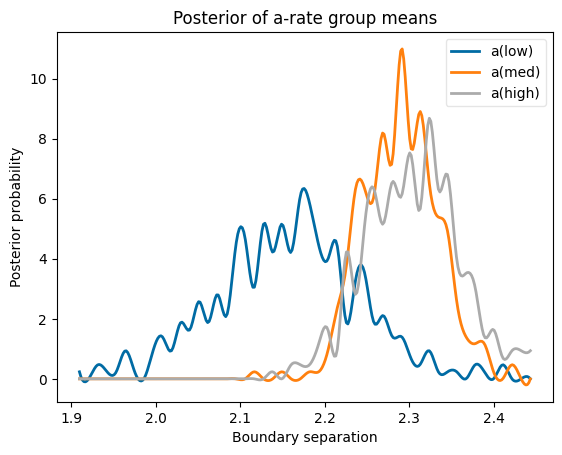

In [157]:
a_low, a_med, a_high = m3_stim.nodes_db.node[["a(low)", "a(med)", "a(high)"]]
hddm.analyze.plot_posterior_nodes([a_low, a_med, a_high])
plt.xlabel("Boundary separation")
plt.ylabel("Posterior probability")
plt.title("Posterior of a-rate group means")

## hddm.HDDMrlRegressor()

HDDM includes a module for estimating the impact of continuous regressor onto RLDDM parameters. The method allows estimation of the association of e.g. neural measures onto parameters. Note that to run the HDDMrlRegressor you need to include alpha when specifying the model. 

In [ ]:
# Run a regressor model estimating the impact of 'mood' on alpha.
m_reg = hddm.HDDMrlRegressor(
    df, "alpha ~ mood_init", include=["v", "a", "t", "alpha"], p_outlier=0.05
)


In [ ]:
m_reg.find_starting_values()

In [164]:
m_reg.sample(300, burn=100)

 [-----------------100%-----------------] 301 of 300 complete in 8939.5 sec

In [165]:
m_reg.print_stats()

                               mean        std       2.5q        25q        50q        75q      97.5q    mc err
a                          1.356914     1.3575        0.0        0.0   2.528275   2.716145   2.809043  0.135724
a_std                      0.350163   0.351396        0.0        0.0   0.596799   0.696967   0.772566  0.035086
a_subj.1                   1.155139   1.164395        0.0        0.0   1.867072   2.304538   2.660222  0.115987
a_subj.2                     1.5752    1.58104        0.0        0.0    2.74102   3.132115   3.504621  0.157775
a_subj.3                      1.298   1.301206        0.0        0.0   2.244006   2.590902   2.816454   0.12995
a_subj.4                   0.966593   0.970428        0.0        0.0   1.603972   1.934599   2.131843  0.096803
a_subj.5                    1.14048   1.141508        0.0        0.0   2.070456    2.28352   2.393179  0.114074
a_subj.6                   1.126113   1.129819        0.0        0.0   1.926722   2.249247   2.455918   

## END

In [19]:
# df1 = df[df['rank'] == 1]
# df1.shape

(7350, 43)

In [ ]:
m1 = hddm.Hrl(
    df, 
    p_outlier=0.05
)


In [85]:
m1.sample(500, burn=100)

 [-----------------100%-----------------] 501 of 500 complete in 218.1 sec

In [86]:
m1.print_stats()

                      mean        std       2.5q        25q         50q         75q       97.5q    mc err
v                19.333893   1.735368  16.001345  18.103574   19.268282   20.600963   22.518022  0.114722
v_std            24.462516   1.194936  22.157298   23.74192   24.441094    25.13486    27.04429  0.095897
v_subj.1           5.94898  22.517013 -36.176405  -9.212573    2.289929   22.676927   51.977652  1.316883
v_subj.2        -26.709385  11.857588 -51.604164  -33.91167  -26.309378  -17.608946   -8.099807  0.800604
v_subj.3          33.42553  19.158312   0.940396  20.342359   32.409208   45.487476   76.117478  1.233335
v_subj.4        -13.410871  14.347476 -43.108186 -22.257398  -13.734533    1.213354    3.189263   1.24698
v_subj.5         26.498314  15.353344    6.35757  14.764313   23.077411   34.446781   64.469472  1.206746
v_subj.6         -5.350487  18.674449 -42.405958 -15.905945   -1.661871    3.029616   43.894239  1.243757
v_subj.7         76.586341  17.583189  47.9235

In [91]:
traces = m1.get_traces()
traces.head()

,v,v_std,v_subj.1,v_subj.2,v_subj.3,v_subj.4,v_subj.5,v_subj.6,v_subj.7,v_subj.8,...,alpha_subj.230,alpha_subj.231,alpha_subj.232,alpha_subj.233,alpha_subj.234,alpha_subj.235,alpha_subj.236,alpha_subj.237,alpha_subj.238,alpha_subj.239
0,16.665887,25.020564,56.216763,-8.477108,53.013718,1.616556,16.549651,11.880625,120.672713,10.743780,...,-4.586823,-10.265618,-11.002983,-3.406493,-5.551180,-1.380080,-4.611749,-2.252811,-4.821438,-2.317835
1,19.966441,24.318664,-31.375918,-24.256634,54.611370,1.401030,17.836381,-12.007079,104.553968,14.585758,...,-4.373723,-11.619081,-13.895994,-3.501336,-5.148710,-1.499338,-4.927239,-2.621795,-4.873030,-2.112752
2,18.092849,24.614245,38.934796,-35.301122,42.124975,2.235718,23.179963,-18.059459,69.630464,8.503821,...,-4.400453,-4.262158,-12.179479,-3.498955,-4.929015,-0.886119,-4.484731,-2.270413,-5.136756,-2.056871
3,17.522587,24.187625,-18.339794,-12.537933,35.742327,2.334195,27.868757,-4.480223,60.095079,8.331417,...,-4.700407,-7.125803,-13.317010,-3.348306,-4.769959,-0.641687,-4.721068,-2.157517,-4.853129,-1.845129
4,19.720877,23.655887,-4.985749,-14.637665,14.328375,1.556415,32.818761,16.147155,58.685777,6.978685,...,-4.299320,-9.852329,-11.602705,-3.043511,-4.348672,0.649060,-4.149008,-2.900163,-3.988501,-1.911778


In [92]:
traces.columns

Index(['v', 'v_std', 'v_subj.1', 'v_subj.2', 'v_subj.3', 'v_subj.4',
       'v_subj.5', 'v_subj.6', 'v_subj.7', 'v_subj.8',
       ...
       'alpha_subj.230', 'alpha_subj.231', 'alpha_subj.232', 'alpha_subj.233',
       'alpha_subj.234', 'alpha_subj.235', 'alpha_subj.236', 'alpha_subj.237',
       'alpha_subj.238', 'alpha_subj.239'],
      dtype='object', length=482)

In [94]:
traces["alpha_subj.1"].mean()

-6.495243910264642

In [95]:
v_cols = traces.filter(like='v_subj')
v_cols.columns

Index(['v_subj.1', 'v_subj.2', 'v_subj.3', 'v_subj.4', 'v_subj.5', 'v_subj.6',
       'v_subj.7', 'v_subj.8', 'v_subj.9', 'v_subj.10',
       ...
       'v_subj.230', 'v_subj.231', 'v_subj.232', 'v_subj.233', 'v_subj.234',
       'v_subj.235', 'v_subj.236', 'v_subj.237', 'v_subj.238', 'v_subj.239'],
      dtype='object', length=239)

In [96]:
v_cols.shape

(400, 239)

In [97]:
v_est = v_cols.mean()
v_est

v_subj.1       5.948980
v_subj.2     -26.709385
v_subj.3      33.425530
v_subj.4     -13.410871
v_subj.5      26.498314
                ...    
v_subj.235    58.139029
v_subj.236    36.755468
v_subj.237    11.784819
v_subj.238    33.471866
v_subj.239    -7.813800
Length: 239, dtype: float64

In [100]:
alpha_cols = traces.filter(like='alpha_subj')
alpha_est = alpha_cols.mean()
alpha_est

alpha_subj.1     -6.495244
alpha_subj.2     -3.980336
alpha_subj.3     -5.418063
alpha_subj.4     -2.032925
alpha_subj.5     -4.764931
                    ...   
alpha_subj.235   -3.782524
alpha_subj.236   -4.541096
alpha_subj.237   -2.728012
alpha_subj.238   -4.606685
alpha_subj.239   -2.266163
Length: 239, dtype: float64

<AxesSubplot: ylabel='Count'>

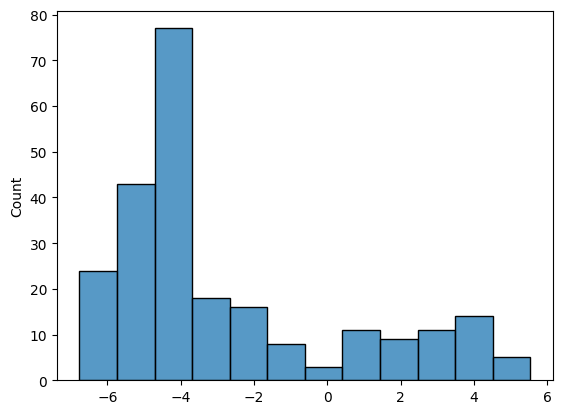

In [101]:
sns.histplot(alpha_est)

In [103]:
mood_scores = df.groupby('subj_idx')['mood'].mean()
mood_scores


subj_idx
1      18.000000
2       0.000000
3       0.666667
4      -3.500000
5     -18.500000
         ...    
235     8.000000
236     2.666667
237    19.000000
238     1.666667
239     3.250000
Name: mood, Length: 239, dtype: float64

In [104]:
dd = pd.DataFrame(
    {
        "mood": np.array(mood_scores),
        "alpha": np.array(alpha_est)
    }
)



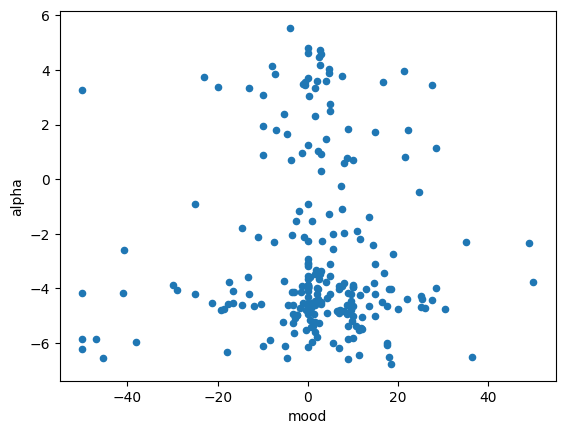

In [105]:
# Create a scatter plot of the 'x' and 'y' columns
dd.plot(kind='scatter', x='mood', y='alpha')
plt.show()

In [54]:
from scipy.stats import spearmanr

rho, pval = spearmanr(dd.mood, dd.alpha)
print("Robust correlation coefficient:", rho)

Robust correlation coefficient: 0.0663009877277603


In [61]:
from scipy.spatial.distance import mahalanobis

# Compute the mean and covariance matrix for the data
mean = np.mean(dd, axis=0)
cov = np.cov(dd, rowvar=False)

# Compute the Mahalanobis distance for each data point
md = np.apply_along_axis(lambda x: mahalanobis(x, mean, np.linalg.inv(cov)), 1, dd)

# Set a threshold to identify outliers
threshold = np.mean(md) + 3*np.std(md)

# Remove outliers from the DataFrame
df_clean = dd[md <= threshold]

# Print the cleaned DataFrame
print(df_clean)

          mood     alpha
0    18.000000 -5.570905
1     0.000000 -6.113240
2     0.666667  0.115286
3    -3.500000 -6.468187
4   -18.500000 -3.531567
..         ...       ...
234   8.000000  0.334021
235   2.666667  0.229202
236  19.000000 -0.769784
237   1.666667  0.198965
238   3.250000 -6.185038

[234 rows x 2 columns]
